# Práctica 2: clasificación con **Árbol de Decisión** vs **SVM** — *Dataset `penguins`*

Vamos a comparar dos modelos de Machine Learning usando el dataset penguins de Seaborn.

## Contexto del estudio: campaña científica en la Antártida

Imagina que formas parte de un equipo de biólogos en la Estación Palmer (Antártida).
Durante varias temporadas, el equipo ha medido a pingüinos de tres especies —Adélie, Chinstrap y Gentoo— que viven en tres islas (Biscoe, Dream y Torgersen). El objetivo es entender cómo varían sus características corporales y si esas diferencias permiten identificar la especie automáticamente.

A partir de esas expediciones tenemos el dataset penguins, con medidas sencillas tomadas en el campo.

## Columnas del dataset

Cada fila representa un pingüino y contiene estas variables:

### species
    Especie del pingüino: Adelie, Chinstrap, Gentoo.

### island
    Isla donde se tomó la medición: Biscoe, Dream, Torgersen.

### bill_length_mm
    Longitud del pico en milímetros.

### bill_depth_mm
    Profundidad del pico (grosor) en milímetros.

### flipper_length_mm
    Longitud de la aleta en milímetros.

### body_mass_g
    Masa corporal en gramos.

### sex
    Sexo del individuo: male / female.


**Objetivo didáctico (simple y guiado):**
1. **EDA** breve del dataset `penguins`.
2. **Ejercicio 1 — Árbol de Decisión (binario):** *Adelie vs No‑Adelie* usando dos medidas corporales.
   - Comparar **accuracy** en función de `max_depth`.
   - Elegir el **mejor depth** según TEST.
   - Ver **regiones de decisión** (TRAIN/TEST).
   - Dibujar el **árbol** con `plot_tree`.
   - Calcular **matriz de confusión** (vista didáctica TP/FP/FN/TN) y métricas.
3. **Ejercicio 2 — SVM (multiclase):** predecir **species** con dos medidas.
   - Tres tomas separadas (lineal, RBF, polinómico) para que el alumno **experimente** con `C`, `gamma`, `degree`.
   - Matrices de confusión + `classification_report` y **regiones de decisión**.
4. **Preguntas finales**.


In [34]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (7.2, 4.8)
plt.rcParams['axes.grid'] = True


## 1) Carga de datos y **EDA** rápido
⚠️ **Obligatorio:** usar `sns.pairplot` para visualizar relaciones entre varias variables a la vez. Así como shape, dtypes, describe, value_counts de la librería Pandas

  species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0  Adelie            39.1           18.7              181.0       3750.0
1  Adelie            39.5           17.4              186.0       3800.0
2  Adelie            40.3           18.0              195.0       3250.0
3  Adelie             NaN            NaN                NaN          NaN
4  Adelie            36.7           19.3              193.0       3450.0
Shape:
(344, 5)
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      342.000000     342.000000         342.000000   342.000000
mean        43.921930      17.151170         200.915205  4201.754386
std          5.459584       1.974793          14.061714   801.954536
min         32.100000      13.100000         172.000000  2700.000000
25%         39.225000      15.600000         190.000000  3550.000000
50%         44.450000      17.300000         197.000000  4050.000000
75%         48.500000      18.700000         213.000000  4750.0

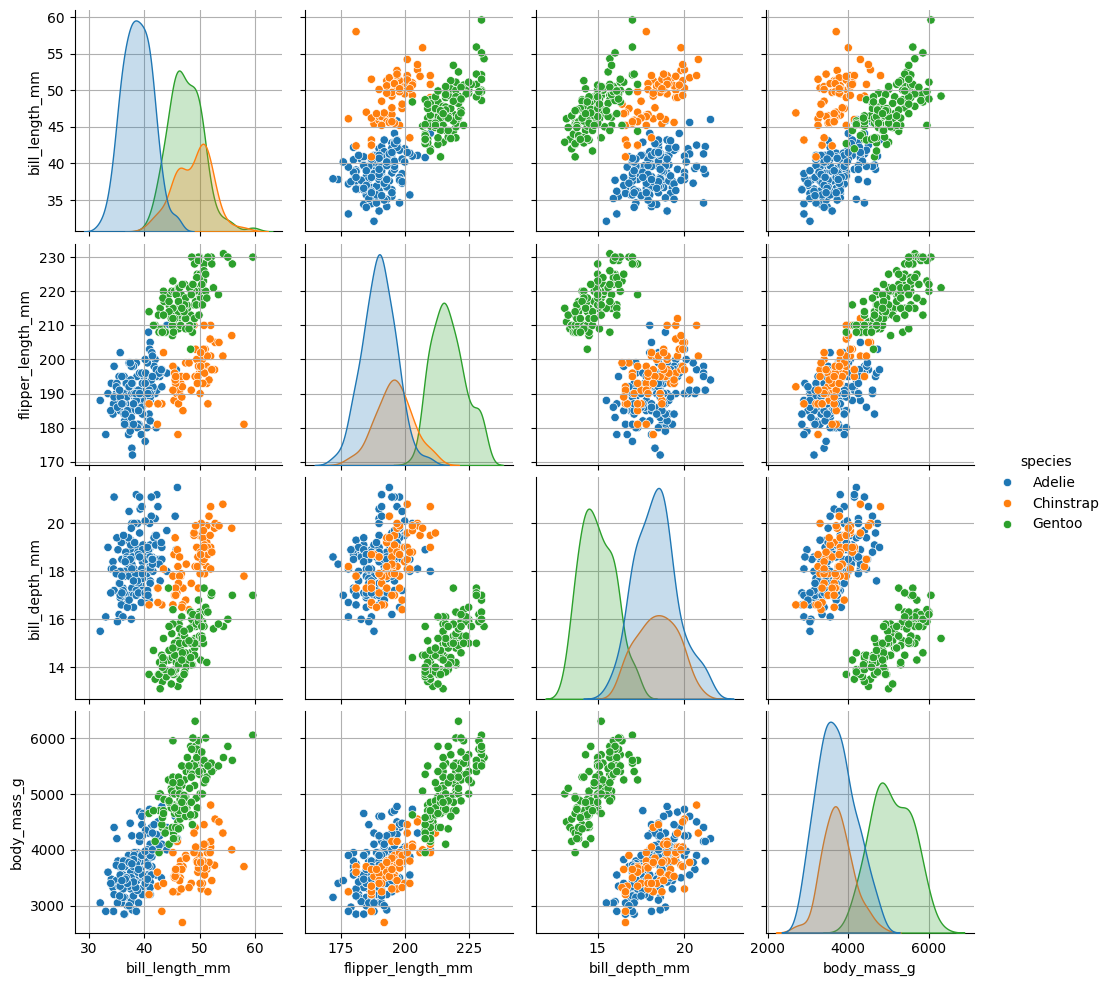

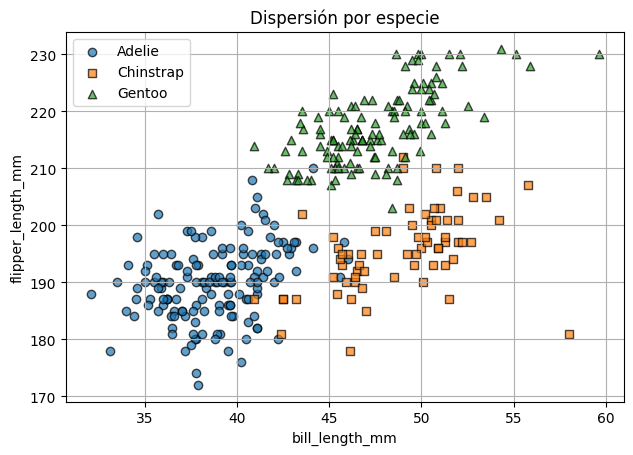

In [35]:
penguins = sns.load_dataset('penguins')
cols = ['species','bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']
df = penguins[cols]

print(df.head())

print("Shape:", )
print(df.shape)

# Descripción numérica (.describe())
print(df.describe())
# Conteo por especie (.value_counts())
print("\nConteo por especie:")
print(df['species'].value_counts())

# isna()
print("\nValores nulos por columna:")
print(df.isna().sum())

# Podemos borrar los valores nulos porque no llegan a ser un 1% del total de los valores, si fuesen más podríamos sustituir
# los valores nulos por la mediana con este código
# numerical_columns = df.select_dtypes(include=['float64' , 'int64']).columns
# for col in numerical_columns:
#     median_value = df[col].median()
#     df[col].fillna(median_value, inplace = True)

df = penguins[cols].dropna().reset_index(drop=True) 

sns.pairplot(df, vars=['bill_length_mm','flipper_length_mm','bill_depth_mm','body_mass_g'], hue='species')
plt.show()


species = df['species'].unique()
markers = ['o','s','^']
plt.figure()
for sp, mk in zip(species, markers):
    mask = df['species']==sp
    plt.scatter(df.loc[mask,'bill_length_mm'],
                df.loc[mask,'flipper_length_mm'],
                marker=mk, alpha=0.7, label=sp, edgecolor='k')
plt.xlabel('bill_length_mm'); plt.ylabel('flipper_length_mm')
plt.title('Dispersión por especie')
plt.legend()
plt.show()


De este EDA podemos concluir que no hay muchos valores nulos en comparación a la cantidad de datos que tenemos (2 nulos vs 344 valores) así que borrar los valores nulos no tendrá grandes consecuencias a la hora de ver la precisión del Árbol/SVM


## 2) **Ejercicio 1 — Árbol de Decisión (binario)** (70/30)
**Target:** `Adelie` (=1) vs `No‑Adelie` (=0)  
**Features:** elige **2** medidas corporales.


Para elegir las 2 medidas corporales más útiles para el árbol de decisión observaremos el pairplot por especies para ver la correlación entra las variables
de medidas corporales. Las combinaciones que podrían funcionar bien son *bill_length_mm vs body_mass_g*, *bill_length_mm vs bill_depth_mm* y *bill_length_mm vs flipper_length_mm*.
Continuaremos con *bill_length_mm vs flipper_length_mm* 


In [36]:
# Elige las variables (cámbialas libremente si lo ves necesario):
FEAT_X = 'bill_length_mm'
FEAT_Y = 'flipper_length_mm'

X = df[[FEAT_X, FEAT_Y]].values
y = (df['species'] == 'Adelie').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

print("Shapes — X_train/X_test:", X_train.shape, X_test.shape)


Shapes — X_train/X_test: (239, 2) (103, 2)


Con este código dividimos el dataframe en train y test con proporción 70/30

### 2.1 Precisión según **max_depth**

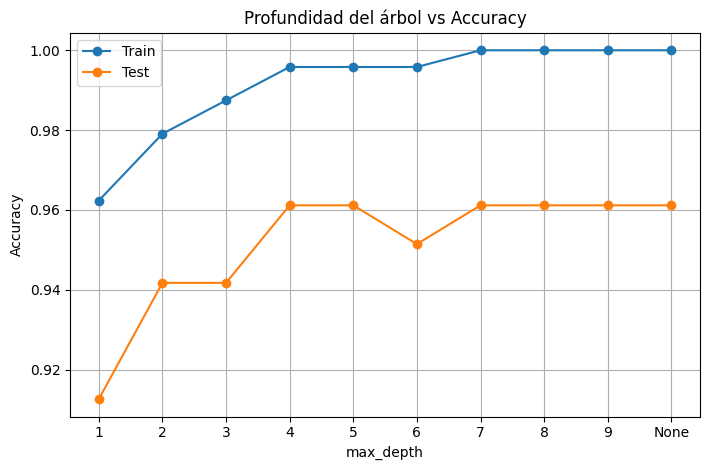

In [37]:
#Establece las profundidades que quieras probar en el árbol
depths = [1,2,3,4,5,6,7,8,9,None]
train_scores, test_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=d)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

x_labels = [str(d) if d is not None else 'None' for d in depths]

plt.figure()
plt.plot(range(len(depths)), train_scores, marker='o', label='Train')
plt.plot(range(len(depths)), test_scores, marker='o', label='Test')
plt.xticks(range(len(depths)), x_labels)
plt.xlabel('max_depth'); plt.ylabel('Accuracy')
plt.title('Profundidad del árbol vs Accuracy'); plt.legend(); plt.tight_layout(); plt.show()



Viendo la gráfica de profundidad vs accuracy nos damos cuenta de que el accuracy de Train alcanza su máximo en profundidad 7 con lo que podemos concluir que a partir de dicha profundidad, el árbol se ajusta por completo a todos los datos de nuestro conjunto (causando el mayor sobreajuste). A priori, la mejor profundidad será **4**, debido a que la precisión de Test es más alta en comparación a Train, pero a la hora de visualizar las regiones de decisión, nos daremos cuenta de que puede haber sobreajuste.

### 2.2 **Regiones de decisión**

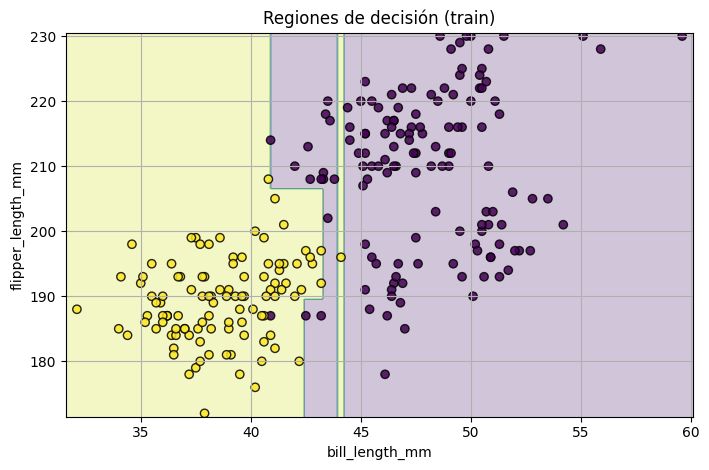

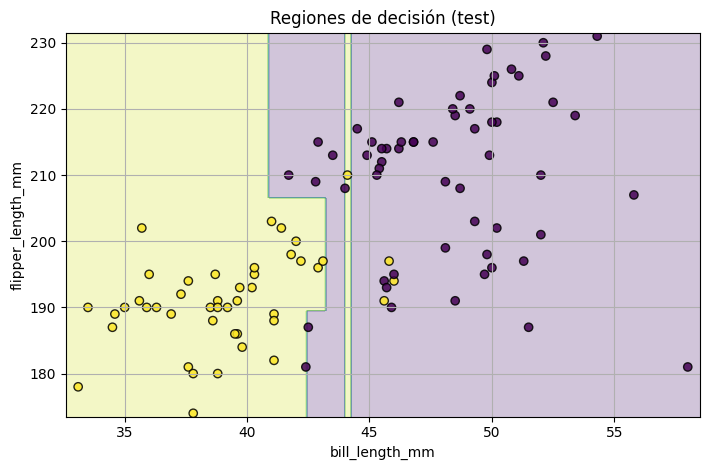

In [38]:

def plot_decision_regions_2d(model, X, y, title='Decision regions'):
    x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', alpha=0.85)
    plt.xlabel(FEAT_X); plt.ylabel(FEAT_Y); plt.title(title)
    plt.tight_layout(); plt.show()
    
best_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4)
best_tree.fit(X_train, y_train)

plot_decision_regions_2d(best_tree, X_train, y_train, title='Regiones de decisión (train)')
plot_decision_regions_2d(best_tree, X_test,  y_test,  title='Regiones de decisión (test)')


Cuando observamos las regiones de decisión con max_depth=4, hay una región que se ajusta a un solo valor (bill_length cerca de 45), tanto en train como en test. Esto es una casualidad y con datos del mundo real dará lugar a una gran cantidad de casos erroneamente clasificados. Lo mismo ocurre con max_depth=3, y solo cuando cambiamos a max_depth=2 vemos unas regiones de decisión *bien ajustadas*. 

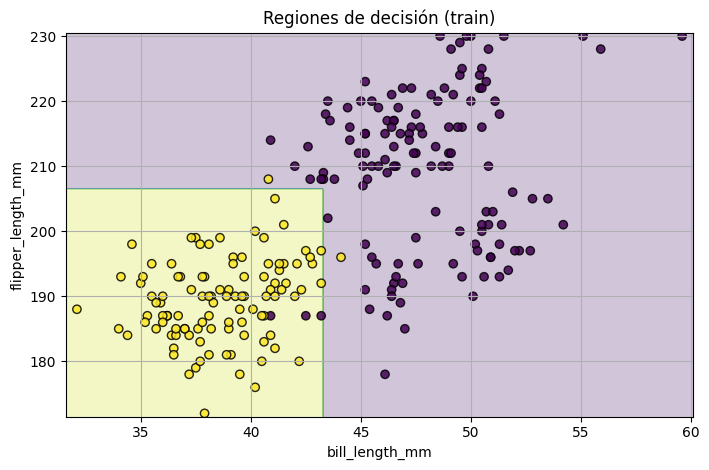

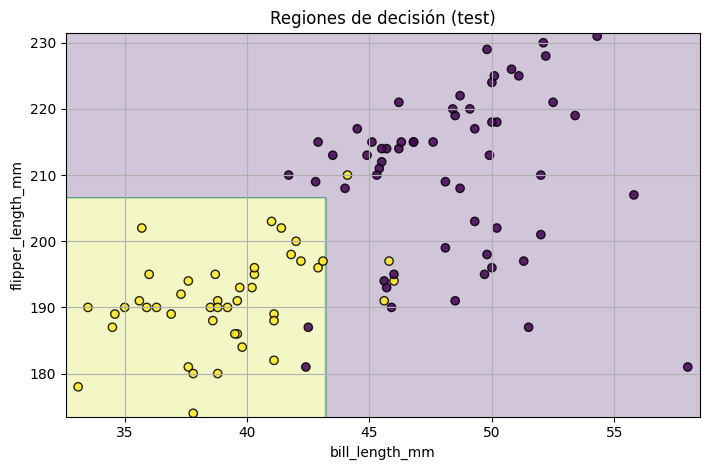

In [39]:
decent_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=2)
decent_tree.fit(X_train, y_train)

plot_decision_regions_2d(decent_tree, X_train, y_train, title='Regiones de decisión (train)')
plot_decision_regions_2d(decent_tree, X_test,  y_test,  title='Regiones de decisión (test)')

Si queremos seguir usando max_depth=4, podríamos cambiar el **random_state** hasta que esa región desaparezca. Por ejemplo, con random_state=124124 las regiones de decisión son más claras, pero, por la continuidad del ejercicio, seguiremos usando la constante RANDOM_STATE=42.

### 2.3 **Árbol** con `plot_tree`

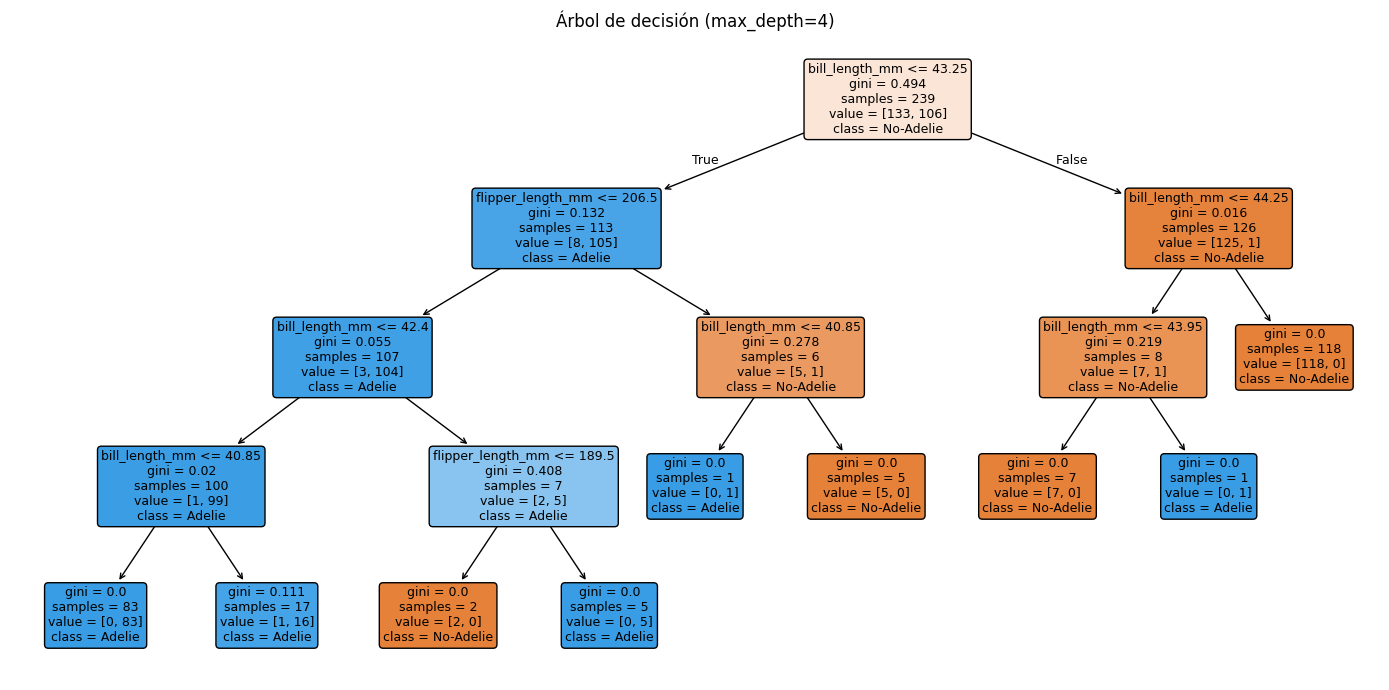

In [40]:
#Siendo best_depth la variable con mejor profundidad, dibuja el árbol. La variable corresponde a la profundidad del apartado 2.1
best_depth = 4
best_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=best_depth).fit(X_train, y_train)

plt.figure(figsize=(14,7))
plot_tree(best_tree,
          feature_names=[FEAT_X, FEAT_Y],
          class_names=['No-Adelie','Adelie'],
          filled=True, rounded=True, fontsize=9)
plt.title(f'Árbol de decisión (max_depth={best_depth})')
plt.tight_layout(); plt.show()


Viendo la representación gráfica del árbol podemos confirmar que con max_depth=4, nuestro modelo se está sobreajustando ya que en las profundidades más bajas, el árbol sigue dividiendo incluso cuando los nodos tienen muy pocas muestras. Hay nodos puros (gini = 0.0) con muestras muy pequeñas, lo cual es indicio de sobreajuste: el modelo está creando reglas muy específicas que probablemente no generalicen bien con datos nuevos.

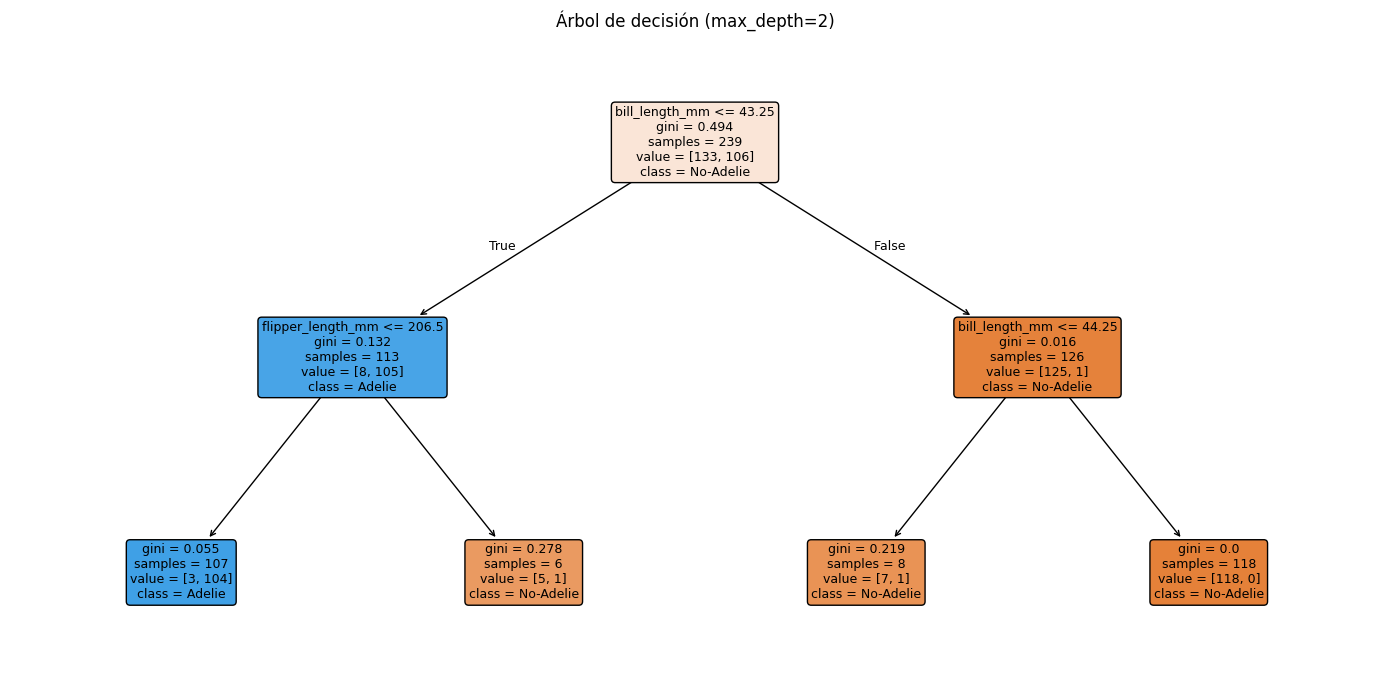

In [41]:
best_depth = 2
best_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=best_depth).fit(X_train, y_train)

plt.figure(figsize=(14,7))
plot_tree(best_tree,
          feature_names=[FEAT_X, FEAT_Y],
          class_names=['No-Adelie','Adelie'],
          filled=True, rounded=True, fontsize=9)
plt.title(f'Árbol de decisión (max_depth={best_depth})')
plt.tight_layout(); plt.show()


Con max_depth=2, el árbol es lo suficientemente simple como para no sobreajustar, pero todavía captura la estructura básica del problema. Las regiones de decisión son simples en ambos conjuntos, lo cual es una buena señal de generalización.

### 2.4 **Matriz de Confusión** métricas

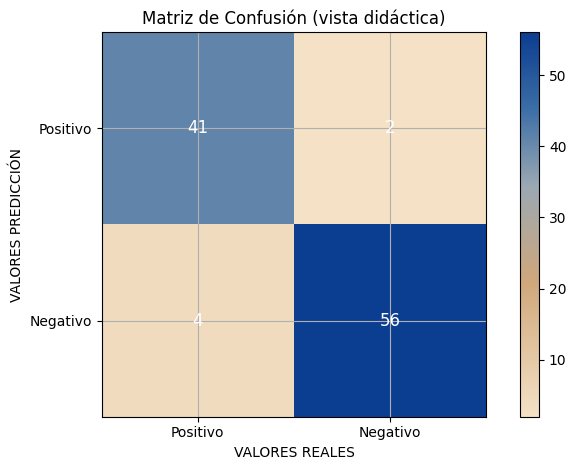

TP, TN, FP, FN = 41 56 2 4
Accuracy : 0.942
Precision: 0.953
Recall   : 0.911
F1-score : 0.932

Informe de clasificación (TEST):

              precision    recall  f1-score   support

   No-Adelie       0.93      0.97      0.95        58
      Adelie       0.95      0.91      0.93        45

    accuracy                           0.94       103
   macro avg       0.94      0.94      0.94       103
weighted avg       0.94      0.94      0.94       103



In [42]:

y_pred_best = best_tree.predict(X_test)
cm_official = confusion_matrix(y_test, y_pred_best, labels=[1,0])
TP, FN, FP, TN = cm_official.ravel()

cm_view = np.array([[TP, FP],
                    [FN, TN]])

brown_to_blue = LinearSegmentedColormap.from_list(
    "brown_to_blue",
    [
        (0.00, "#F4E1C6"),
        (0.35, "#CFA77B"),
        (0.60, "#9BA8B3"),
        (0.80, "#3C6EA6"),
        (1.00, "#0B3D91"),
    ],
    N=256
)

fig, ax = plt.subplots()
im = ax.imshow(cm_view, cmap=brown_to_blue)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Positivo','Negativo'])
ax.set_yticklabels(['Positivo','Negativo'])
ax.set_xlabel('VALORES REALES'); ax.set_ylabel('VALORES PREDICCIÓN')
plt.colorbar(im, ax=ax)

for i in range(2):
    for j in range(2):
        ax.text(j, i, int(cm_view[i, j]), ha='center', va='center', color='white', fontsize=12)

plt.title('Matriz de Confusión (vista didáctica)')
plt.tight_layout(); plt.show()

acc  = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best, zero_division=0)
rec  = recall_score(y_test, y_pred_best, zero_division=0)
f1   = f1_score(y_test, y_pred_best, zero_division=0)

print(f"TP, TN, FP, FN = {TP} {TN} {FP} {FN}")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print('\nInforme de clasificación (TEST):\n')
print(classification_report(y_test, y_pred_best, digits=2, target_names=['No-Adelie','Adelie']))


Viendo la matriz de confusión y las métricas, podemos concluir que, aunque la profundidad sea aparentemente baja, el modelo generaliza bien y no hay demasiado desequilibrio en los errores (FN y FP están en el mismo orden de magnitud)


## 3) **Ejercicio 2 — SVM (Binario: Adelie vs No-Adelie)**
Usamos las mismas features para comparar.


In [43]:

Xs = df[[FEAT_X, FEAT_Y]].values
ys = (df['species'] == 'Adelie').astype(int).values 	# Esta línea hace que nuestro SVM sea binario (Adelie vs No-Adelie)
# ys = df['species'].values								# De esta manera, nuestro SVM sería multiclases

Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(
    Xs, ys, test_size=0.3, random_state=RANDOM_STATE, stratify=ys
)

###########
# No tocar nada
def plot_cm(cm, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(classes))); ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    ax.set_xlabel('Predicción'); ax.set_ylabel('Real')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center', color='black')
    plt.colorbar(im, ax=ax)
    plt.title(title); plt.tight_layout(); plt.show()

def plot_regions_multiclass(model, X, y, title):
    x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
    y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z_lab = model.predict(grid).reshape(xx.shape)
    classes = model.classes_
    mapping = {cls:i for i,cls in enumerate(classes)}
    Z = np.vectorize(mapping.get)(Z_lab)
    y_num = np.vectorize(mapping.get)(y)
    cmap = ListedColormap(['#1f77b4', '#d62728', '#2ca02c'])
    plt.figure(figsize=(6.5,5))
    plt.contourf(xx, yy, Z, levels=np.arange(len(classes)+1)-0.5, cmap=cmap, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y_num, cmap=cmap, edgecolor='k', alpha=0.9)
    plt.xlabel(FEAT_X); plt.ylabel(FEAT_Y)
    plt.title(title + f"  (clases: {classes.tolist()})")
    plt.tight_layout(); plt.show()


### 3.1 **SVM lineal** (punto de partida)

=== SVM lineal ===
Accuracy (train/test): 0.971 / 0.942


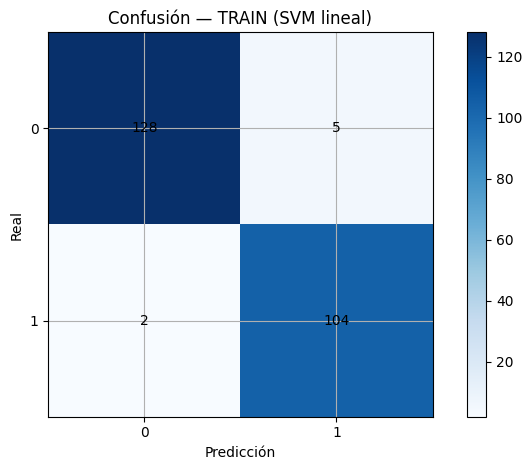

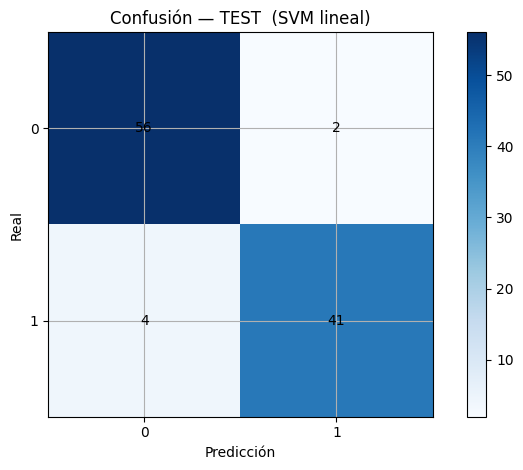

Classification report (TEST):
               precision    recall  f1-score   support

           0      0.933     0.966     0.949        58
           1      0.953     0.911     0.932        45

    accuracy                          0.942       103
   macro avg      0.943     0.938     0.940       103
weighted avg      0.942     0.942     0.942       103



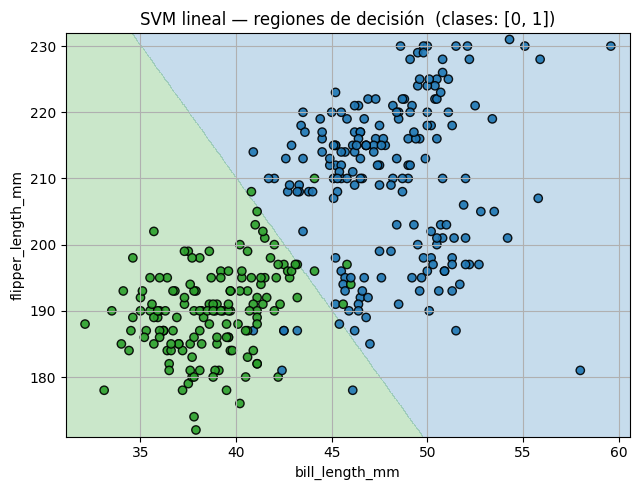

In [44]:
### Monta la Pipeline del SVM Lineal
svm_lin = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='linear', C=0.01, random_state=RANDOM_STATE))
])

svm_lin.fit(Xs_tr, ys_tr)
pred_tr = svm_lin.predict(Xs_tr)
pred_te = svm_lin.predict(Xs_te)

print("=== SVM lineal ===")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_lin.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_lin.classes_)
plot_cm(cm_tr, svm_lin.classes_, "Confusión — TRAIN (SVM lineal)")
plot_cm(cm_te, svm_lin.classes_, "Confusión — TEST  (SVM lineal)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_lin, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM lineal — regiones de decisión")


Con este SVM lineal, cambiar el hiperparámetro C no tiene consecuencias considerables, aunque vemos que con C=0.01, conseguimos una matriz de confusión idéntica a la que teníamos con el árbol de max_depth=2

### 3.2 **SVM RBF** (curvatura con `gamma`)


=== SVM RBF ===
Accuracy (train/test): 0.996 / 0.961


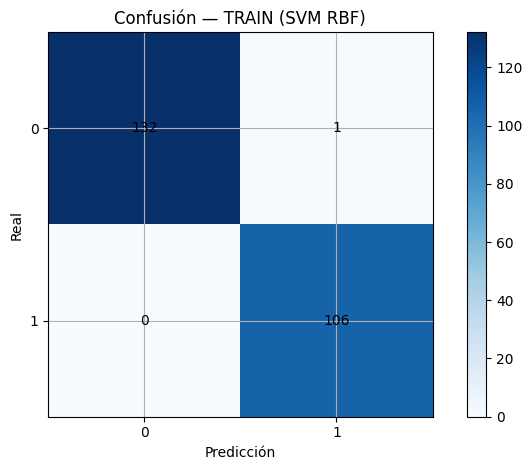

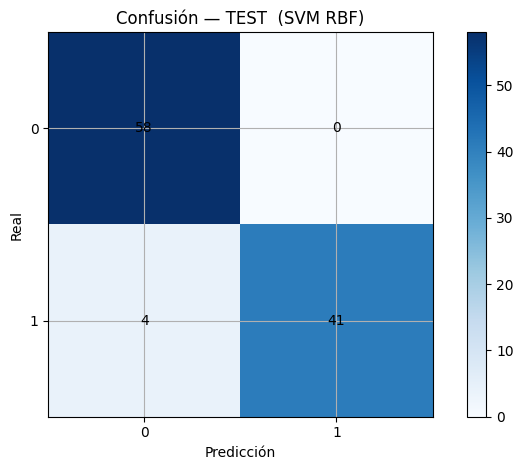

Classification report (TEST):
               precision    recall  f1-score   support

           0      0.935     1.000     0.967        58
           1      1.000     0.911     0.953        45

    accuracy                          0.961       103
   macro avg      0.968     0.956     0.960       103
weighted avg      0.964     0.961     0.961       103



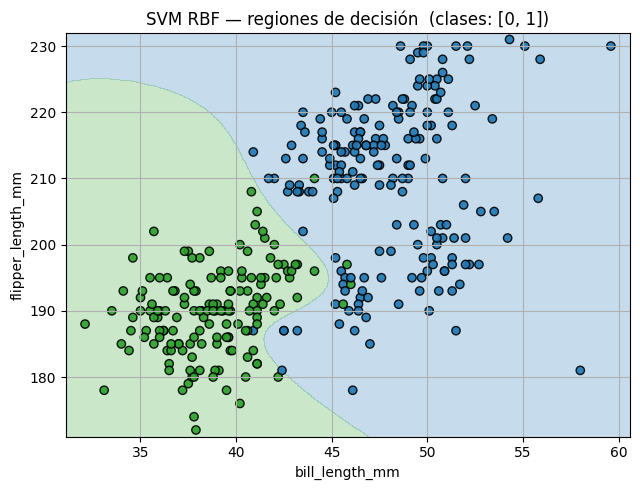

In [45]:
### Monta la Pipeline del SVM con Kernel RBF
svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='rbf', C=200, gamma=1, random_state=RANDOM_STATE))
])

svm_rbf.fit(Xs_tr, ys_tr)
pred_tr = svm_rbf.predict(Xs_tr)
pred_te = svm_rbf.predict(Xs_te)

print("\n=== SVM RBF ===")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_rbf.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_rbf.classes_)
plot_cm(cm_tr, svm_rbf.classes_, "Confusión — TRAIN (SVM RBF)")
plot_cm(cm_te, svm_rbf.classes_, "Confusión — TEST  (SVM RBF)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_rbf, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM RBF — regiones de decisión")


Con el kernel='rbf' nuestra accuracy es mayor aún comparado con el kernel lineal. Tras ajustar los hiperparámetros C y Gamma, los valores que consiguen un accuracy en Test más alto son C=200 y gamma=1

### 3.3 **SVM polinómico** (control con `degree`)


=== SVM polinómico ===
Accuracy (train/test): 0.958 / 0.913


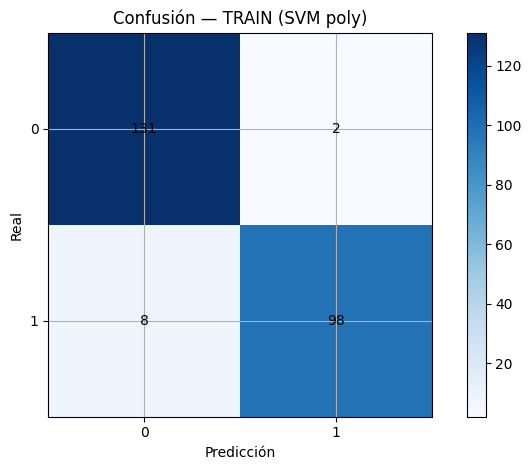

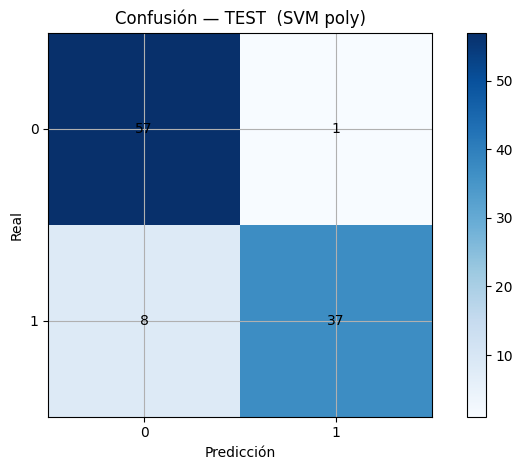

Classification report (TEST):
               precision    recall  f1-score   support

           0      0.877     0.983     0.927        58
           1      0.974     0.822     0.892        45

    accuracy                          0.913       103
   macro avg      0.925     0.902     0.909       103
weighted avg      0.919     0.913     0.911       103



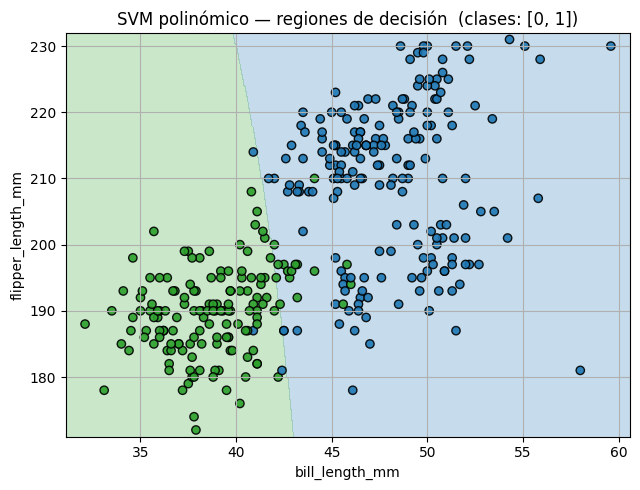

In [46]:
### Monta la Pipeline del SVM con Kernel Poly
svm_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='poly', degree=3, C=50, gamma=5, random_state=RANDOM_STATE))
])

svm_poly.fit(Xs_tr, ys_tr)
pred_tr = svm_poly.predict(Xs_tr)
pred_te = svm_poly.predict(Xs_te)

print("\n=== SVM polinómico ===")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_poly.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_poly.classes_)
plot_cm(cm_tr, svm_poly.classes_, "Confusión — TRAIN (SVM poly)")
plot_cm(cm_te, svm_poly.classes_, "Confusión — TEST  (SVM poly)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_poly, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM polinómico — regiones de decisión")


Cuando ajustamos los hiperparámetros del SVM polinómico vemos que con polinomios de grado par, las regiones de decisión parcen tener cierta simetría, porque el modelo intenta ajustar una función parabólica o elíptica a nuestro dataset. Esto puede funcionar si nuestros datos tienen algo de simetría, pero en este caso nos irá mejor con un grado impar, en este caso 3. Si asignamos C=50 y gamma=5, las regiones de decisión se asemejan al SVM lineal, porque al aumentar estos valores, decrece la curvatura de nuestra frontera. Aún así, no he conseguido que este modelo sea muy preciso, y de los SVM, es el que peor rendimiento tiene.


## 4) Preguntas para entregar

1. ¿Qué `max_depth` ofrece mejor **accuracy de TEST** en el árbol? ¿Por qué no conviene usar `None` por defecto?

	>	El max_depth que ofrece mejor accuracy de Test es 4 o 5 (accuracy de train y test iguales en depth 4 y 5). No conviene usar None por defecto porque recorrerá todos los valores del dataset, generando un sobreajuste 

2. Mira la frontera del árbol en TEST. ¿Dónde ves **sobreajuste**?

	>	Con max_depth 4 e incluso 3, observamos que una de las regiones que genera es una zona vertical muy fina, que solo se ajusta a un único valor que casualmente luego es un VP en el test. Por eso he decidido que el mejor depth sería 2, donde las divisiones son límpias y no hay sobreajuste (aunque la precisión sea ínfimamente menor) 

3. Compara las **matrices de confusión** del árbol y del SVM lineal: ¿cuál equilibra mejor aciertos en cada clase?

	>	En este caso, con el árbol con max_depth=2 y el SVM lineal con C=0.01, las matrices de confusión son **idénticas**

4. En SVM **RBF**, modifica `gamma` y `C` (0.1, 1, 10): ¿cómo cambia la frontera y el accuracy de TEST? Explica el rol de cada hiperparámetro.

	>	Vemos que cuando los valores de gamma y C son más elevados las regiones son más cerradas y alcanzamos un sobreajuste (con c=100 y gamma=100, las regiones son completamente cerradas y encierran cada punto), y si por el contrario las dejamos con un valor bajo (gamma=0.01), las fronteras de decisión se vuelven básicamente lineales. 

5. En SVM **polinómico**, prueba `degree=2` y `degree=4`. ¿Mejora el test? ¿Qué efecto visual observas al aumentar el grado?

	>	Vemos que con degree=4 alcanza un accuracy un poco más alto, pero no es suficientemente preciso. Además vemos que con polinomios de grado par, las regiones de decisión son simétricas, lo que da lugar a error. Si probamos con un grado impar (3 por ejemplo) las regiones se adaptan mejor a cada conjunto de datos.
